In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, BatchNormalization, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import wget
import os
sns.set_context("talk")
sns.set_style("whitegrid")

In [2]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
lvar2plot = [(21,'psio2',r'$\Psi_{o,2}$'),(29,'thetao2',r'$\theta_{o,2}$'),(0,'psia1',r'$\Psi_{a,1}$')]

In [3]:
def load_data(indir,fname,ftpurl=None,ftpdir=None,):
    """Load data in the file fname from the the indir.
    If ftpurl and ftpdir are set, first download the data from the ftp url"""
    if ftpurl:
        # Save the existing file
        if os.path.isfile(os.path.join(indir,fname)):
            os.rename(os.path.join(indir,fname),os.path.join(indir,fname+'.save'))
        assert ftpdir, 'if ftpurl is set, the argument ftpdir has to be set'
        full_url = os.path.join(ftpurl,ftpdir,fname)
        print(full_url)
        wget.download(full_url,out=indir)
    data = np.load(os.path.join(indir,fname))
    return data


In [4]:
filename = 'train-dtObs10-T200000.0-true.npz'

if os.path.isfile(filename):
    ftpurl = None
    ftpdir = None
else:
    print('download data on ftp') 
    ftpurl = 'ftp://ftp.nersc.no/reddaml/'
    ftpdir = 'share'
data = load_data('.',filename,ftpurl=ftpurl,ftpdir=ftpdir)

In [5]:
burn = 0
xx = data['x'][burn:]
yy = data['y'][burn:]
scaler_x.fit(xx);
scaler_y.fit(yy);

In [6]:
ival = -1000
xx_train = xx[:ival]
yy_train = yy[:ival]
xx_val = xx[ival:]
yy_val = yy[ival:]

In [7]:
m = xx.shape[1]
archi = [(100, 'relu'), (50, 'relu')]
reg = 0.0001
batchlayer = {0}
optimizer = 'RMSprop'
batch_size = 128

In [8]:
def buildmodel_dense(archi, m=36, reg=1e-4, batchlayer={0,1}):
    """
    If change buildmodel input args, should echeck train and buil hybrid
    :param archi:
    :param m:
    :param reg:
    :param batchlayer:
    :return:
    """
    inputs = Input(shape=(m,))
    if 0 in batchlayer:
        x = BatchNormalization()(inputs)
    else:
        x = inputs
    for i, (nneur, activ) in enumerate(archi):
        if i+1 in batchlayer:
            x = BatchNormalization()(x)
        x = Dense(nneur, activation=activ)(x)
    output = Dense(m, activation='linear', kernel_regularizer=regularizers.l2(reg))(x)
    return Model(inputs, output)

In [9]:
kw_modelargs = {
        'archi': archi,
        'm':xx.shape[1],
        'reg': reg,
        'batchlayer':batchlayer
    }
model = buildmodel_dense(**kw_modelargs)

In [10]:
model.compile(loss='mse', optimizer=optimizer)


In [11]:
history = model.fit(scaler_x.transform(xx_train),scaler_y.transform(yy_train),
                    epochs=300, batch_size=batch_size,
                    validation_data=(scaler_x.transform(xx_val),scaler_y.transform(yy_val)))


Epoch 1/300
149/149 [==============================] - 2s 4ms/step - loss: 0.6721 - val_loss: 0.5951
Epoch 2/300
149/149 [==============================] - 0s 3ms/step - loss: 0.4509 - val_loss: 0.4851
Epoch 3/300
149/149 [==============================] - 0s 3ms/step - loss: 0.3859 - val_loss: 0.4388
Epoch 4/300
149/149 [==============================] - 0s 3ms/step - loss: 0.3499 - val_loss: 0.4091
Epoch 5/300
149/149 [==============================] - 0s 3ms/step - loss: 0.3267 - val_loss: 0.3657
Epoch 6/300
149/149 [==============================] - 0s 3ms/step - loss: 0.3096 - val_loss: 0.3476
Epoch 7/300
149/149 [==============================] - 0s 3ms/step - loss: 0.2971 - val_loss: 0.3528
Epoch 8/300
149/149 [==============================] - 0s 3ms/step - loss: 0.2871 - val_loss: 0.3236
Epoch 9/300
149/149 [==============================] - 0s 3ms/step - loss: 0.2779 - val_loss: 0.3058
Epoch 10/300
149/149 [==============================] - 0s 3ms/step - loss: 0.2715 - val_lo

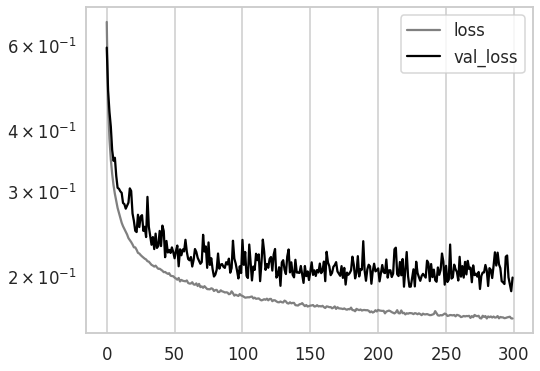

In [12]:
fig, ax  = plt.subplots(figsize=(8,6))
ax.semilogy(history.history['loss'],label='loss',color='gray')
ax.semilogy(history.history['val_loss'], label='val_loss', color='black')
ax.legend();

In [13]:
ypred = scaler_y.inverse_transform(model.predict(scaler_x.transform(xx)).squeeze())

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


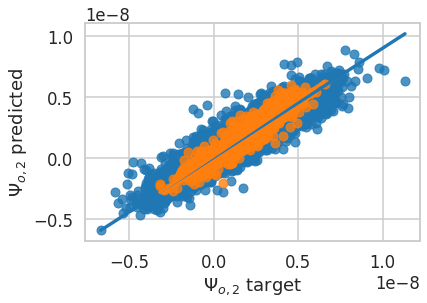

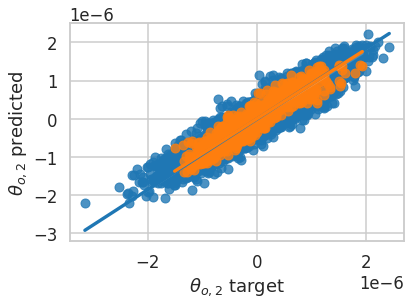

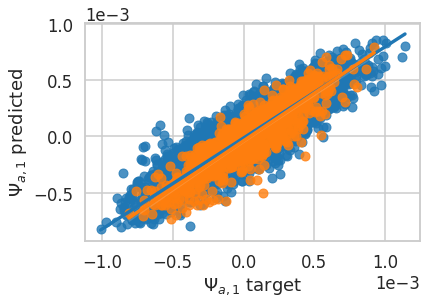

In [14]:
for var2plot in lvar2plot:
    i, var, strvar = var2plot
    fig, ax = plt.subplots()
    sns.regplot(yy[:ival, i], ypred[:ival, i], ax=ax) # Blue
    sns.regplot(yy[ival:, i], ypred[ival:, i], ax=ax) # Orange
    ax.set_xlabel('{} target'.format(strvar))
    ax.set_ylabel('{} predicted'.format(strvar))
    ax.ticklabel_format(style='sci', scilimits=(0, 0))

FOR INFORMATION, definition of the hybrid model. It is a function taking as an input the Hidden markov mode, as defined in DAPPER and return the hybrid model.
I put also ``load_nn`` to be complete
The ``kw_modelargs`` strucutre loaded in ``load_nn`` is the same as the ``kw_modelargs`` defined above.
In practice nnfile corresponds to 4 files that gices the atchitecture of the neural net, the weights, the scaling for the input and the scaling for the output.
This structure is probably a bit deprecated now



In [15]:
def build_hybrid(HMM, nnfile):
    HMM_hybrid = copy.deepcopy(HMM)

    model_nn, scaler_x, scaler_y = load_nn(nnfile)
    def step (x0, t0, dt):
        return HMM.Dyn.model(x0,t0,dt)+dt*scaler_y.inverse_transform(model_nn.predict(scaler_x.transform(x0)))
    HMM_hybrid.Dyn.model = step
    HMM_hybrid.Dyn.nn = model_nn
    HMM_hybrid.Dyn.scaler_x = scaler_x
    HMM_hybrid.Dyn.scaler_y = scaler_y
    return HMM_hybrid

In [16]:
def load_nn(nnfile):
    kw_modelargs = joblib.load(nnfile.format('nnparam')+'.pkl')
    model_nn = buildmodel_dense(**kw_modelargs)
    model_nn.load_weights(nnfile.format('weights')+'.h5')
    scaler_x = joblib.load(nnfile.format('scalerx') + '.pkl')
    scaler_y = joblib.load(nnfile.format('scalery') + '.pkl')
    return model_nn, scaler_x, scaler_y